<a href="https://colab.research.google.com/github/bartteeuwen/USD-ML-and-DL-for-Data-Science/blob/main/Group_5_Final_Project_NA_Renewable_Energy_and%20AI_Predictive_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

In [1]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection   import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.preprocessing     import StandardScaler, OneHotEncoder
from sklearn.impute            import SimpleImputer
from sklearn.compose           import ColumnTransformer
from sklearn.pipeline          import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

**Data Loading**

In [2]:
!wget -q --no-check-certificate \
  'https://docs.google.com/uc?export=download&id=1isaPwtskXj0gZ5KxPVfOTFAN7_cKR1t_' \
  -O global_power_plant_database.csv

path_to_file= '/content/global_power_plant_database.csv'
raw = pd.read_csv('global_power_plant_database.csv', low_memory=False)

In [3]:
# Load & Filter to North America + Sustainable Fuels
sustainable_fuels = ['Solar', 'Hydro', 'Wind', 'Wave and Tidal', 'Geothermal', 'Biomass']

df = (
    pd.read_csv('global_power_plant_database.csv', low_memory=False)
      .loc[lambda d: d['country'].isin(['USA', 'CAN'])]      # North America only
      .loc[lambda d: d['primary_fuel'].isin(sustainable_fuels)]
      .copy()
)

print("Filtered rows:", len(df))

# Ensure generation columns are numeric (GWh)
year_columns_actual = [
    'generation_gwh_2013','generation_gwh_2014','generation_gwh_2015',
    'generation_gwh_2016','generation_gwh_2017','generation_gwh_2018','generation_gwh_2019'
]
year_columns_estimated = [
    'estimated_generation_gwh_2013','estimated_generation_gwh_2014','estimated_generation_gwh_2015',
    'estimated_generation_gwh_2016','estimated_generation_gwh_2017'
]
all_year_cols = year_columns_actual + year_columns_estimated

for c in all_year_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Helper to convert totals from GWh → TWh
def gwh_to_twh(x):
    return x / 1_000.0

Filtered rows: 7141


**Exploratory Data Analysis (EDA)**

In [4]:
print(df.head)

<bound method NDFrame.head of       country              country_long                                  name  \
3594      CAN                    Canada                        13th Side Road   
3595      CAN                    Canada                            Aberfeldie   
3596      CAN                    Canada                        Abitibi Canyon   
3597      CAN                    Canada                             Abénaquis   
3598      CAN                    Canada                       Adam-Cunningham   
...       ...                       ...                                   ...   
34532     USA  United States of America                 Zeeland Farm Services   
34534     USA  United States of America                           Zephyr Wind   
34535     USA  United States of America  Zero Waste Energy Development Co LLC   
34540     USA  United States of America              Zotos International WPGF   
34541     USA  United States of America         Zumbro Community Solar Garden  

In [5]:
# Unique
df['primary_fuel'].unique()

array(['Solar', 'Hydro', 'Wind', 'Biomass', 'Wave and Tidal',
       'Geothermal'], dtype=object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7141 entries, 3594 to 34541
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   country                         7141 non-null   object 
 1   country_long                    7141 non-null   object 
 2   name                            7141 non-null   object 
 3   gppd_idnr                       7141 non-null   object 
 4   capacity_mw                     7141 non-null   float64
 5   latitude                        7141 non-null   float64
 6   longitude                       7141 non-null   float64
 7   primary_fuel                    7141 non-null   object 
 8   other_fuel1                     168 non-null    object 
 9   other_fuel2                     64 non-null     object 
 10  other_fuel3                     38 non-null     object 
 11  commissioning_year              6078 non-null   float64
 12  owner                           680

In [7]:
missing_counts = df.isnull().sum()

# Calculate missing value percentages
missing_percent = (missing_counts / len(df)) * 100

# Combine into a summary dataframe
missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing %': missing_percent.round(1)
}).sort_values(by='Missing %', ascending=False)
print(missing_summary)

                                Missing Count  Missing %
other_fuel3                              7103       99.5
other_fuel2                              7077       99.1
other_fuel1                              6973       97.6
generation_gwh_2013                      4172       58.4
estimated_generation_gwh_2013            3845       53.8
generation_gwh_2014                      3806       53.3
wepp_id                                  3661       51.3
estimated_generation_gwh_2014            3547       49.7
generation_gwh_2015                      3418       47.9
estimated_generation_gwh_2015            3210       45.0
estimated_generation_gwh_2016            2854       40.0
generation_gwh_2016                      2762       38.7
generation_gwh_2017                      2200       30.8
generation_gwh_2018                      1712       24.0
generation_gwh_2019                      1110       15.5
generation_data_source                   1089       15.2
commissioning_year             

In [8]:
df.describe()

,capacity_mw,latitude,longitude,commissioning_year,year_of_capacity_data,generation_gwh_2013,generation_gwh_2014,generation_gwh_2015,generation_gwh_2016,generation_gwh_2017,generation_gwh_2018,generation_gwh_2019,estimated_generation_gwh_2013,estimated_generation_gwh_2014,estimated_generation_gwh_2015,estimated_generation_gwh_2016,estimated_generation_gwh_2017
count,7141.000000,7141.000000,7141.00000,6078.000000,7114.000000,2969.000000,3335.000000,3723.000000,4379.000000,4941.000000,5429.000000,6031.000000,3296.000000,3594.000000,3931.00000,4287.000000,6876.000000
mean,49.085821,40.304035,-93.12150,2000.568556,2018.492972,159.847726,145.726671,133.273439,128.197445,128.851178,121.198545,114.484348,261.656183,246.040810,219.87654,217.693854,160.098178
std,193.535418,5.745486,19.43955,28.159444,1.923028,658.328399,622.177538,572.096405,549.570162,558.693040,537.815020,461.500054,1199.152659,1141.298845,1145.56145,1060.185336,833.029699
min,1.000000,13.303500,-159.76210,1896.000000,2000.000000,-947.600000,-989.619000,-864.428000,-768.620000,-934.944000,-982.622000,-780.339000,1.120000,0.870000,0.94000,0.570000,0.690000
25%,2.000000,35.586100,-112.98890,1999.000000,2019.000000,4.728000,3.778500,3.705000,3.499500,3.434000,3.294000,3.179500,7.810000,7.175000,5.97000,5.850000,4.277500
50%,5.000000,40.817000,-88.24450,2013.782000,2019.000000,23.484000,16.601000,13.754000,11.317000,10.395000,9.353000,9.170000,27.595000,25.410000,19.11000,18.100000,11.785000
75%,30.000000,44.245600,-76.79940,2017.000000,2019.000000,143.171000,117.725500,101.980000,87.169500,85.071000,72.330000,65.405500,164.537500,156.795000,117.20500,120.830000,81.470000
max,6809.000000,64.491200,144.74920,2020.000000,2019.000000,21073.181000,20261.569000,18878.623000,19011.492000,20983.990000,21042.561000,16909.302000,33056.170000,32892.490000,33342.94000,32982.610000,32690.160000


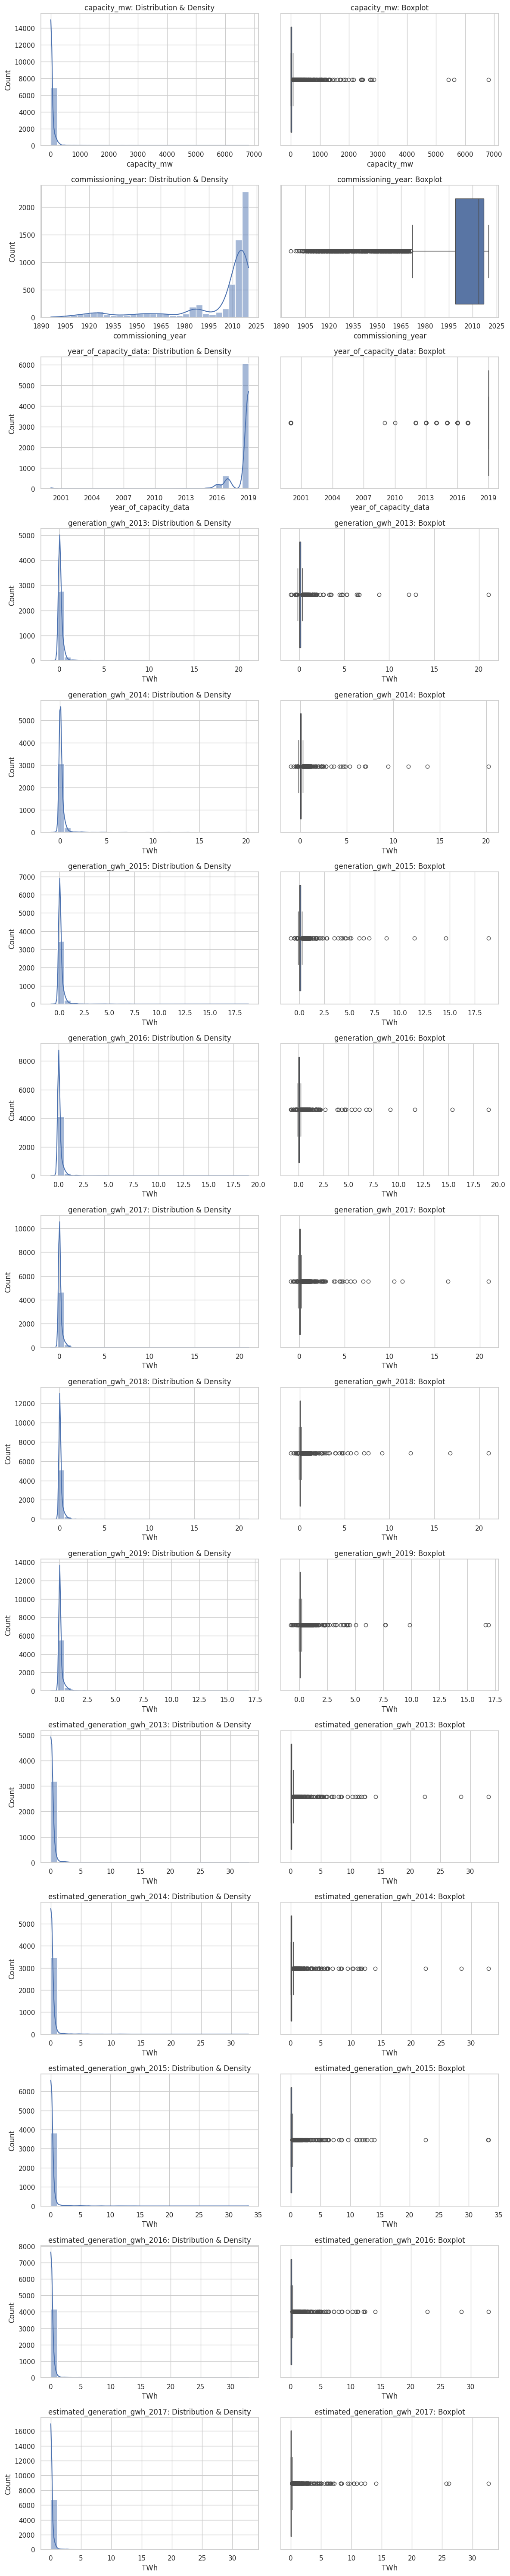

In [9]:
sns.set(style="whitegrid")

numeric_columns = [
    'capacity_mw', 'commissioning_year', 'year_of_capacity_data',
    *year_columns_actual, *year_columns_estimated
]

n_cols = 2
n_rows = len(numeric_columns)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))

for idx, col in enumerate(numeric_columns):
    series = df[col].dropna()
    # convert generation columns to TWh for consistency in paper
    if col.startswith('generation_gwh_') or col.startswith('estimated_generation_gwh_'):
        series = series / 1_000

    sns.histplot(series, kde=True, bins=30, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{col}: Distribution & Density')
    axes[idx, 0].set_xlabel('TWh' if 'gwh' in col else col)

    sns.boxplot(x=series, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{col}: Boxplot')
    axes[idx, 1].set_xlabel('TWh' if 'gwh' in col else col)

    if 'year' in col or 'year_of_capacity_data' in col:
        for ax in [axes[idx, 0], axes[idx, 1]]:
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

North America total renewables, 2019: 690.5 TWh


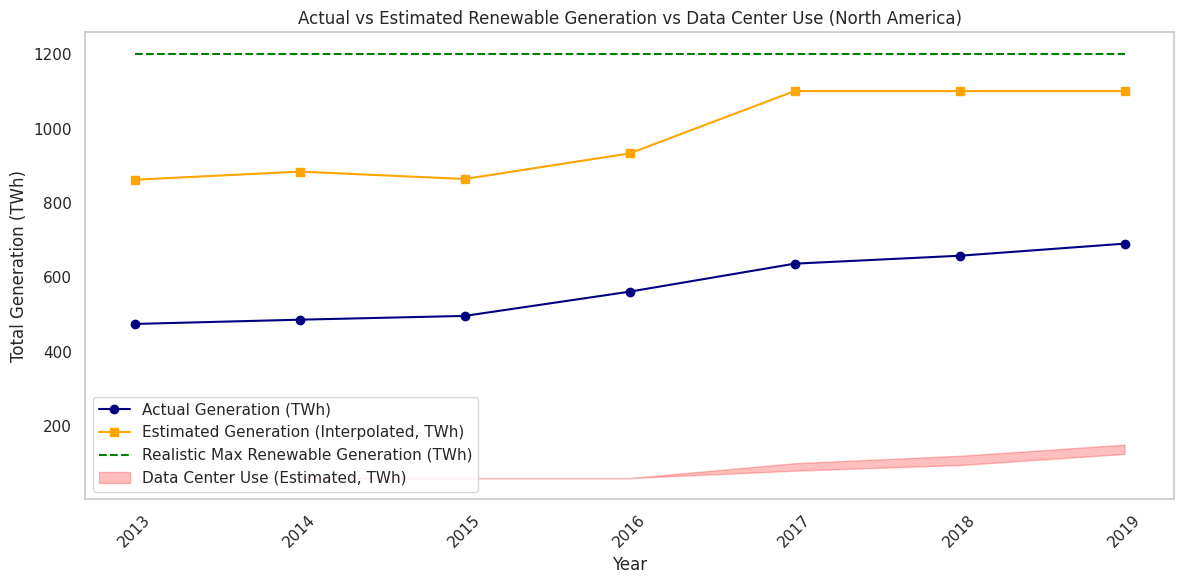

In [10]:
# Years on the x-axis
years_all = sorted({int(c.split('_')[-1]) for c in year_columns_actual + year_columns_estimated})

# Aggregate to North America totals (GWh → TWh)
actual_generation_gwh    = df[year_columns_actual].sum(numeric_only=True)
estimated_generation_gwh = df[year_columns_estimated].sum(numeric_only=True)

# Reindex to full year list & linearly fill estimated where missing
actual_generation_gwh    = actual_generation_gwh.reindex([f'generation_gwh_{y}' for y in years_all], fill_value=0)
estimated_generation_gwh = estimated_generation_gwh.reindex([f'estimated_generation_gwh_{y}' for y in years_all]).interpolate('linear')

# Convert to TWh for plotting/text
actual_generation_twh    = gwh_to_twh(actual_generation_gwh.values)
estimated_generation_twh = gwh_to_twh(estimated_generation_gwh.values)

# Capacity-based realistic max line (TWh)
weights_raw = {'Wind': 0.33, 'Hydro': 0.53, 'Solar': 0.27, 'Biomass': 0.07, 'Geothermal': 0.015}
w_sum = sum(weights_raw.values())
fuel_weights = {k: v / w_sum for k, v in weights_raw.items()}  # normalize to 1.0

capacity_factors = {  # average CFs
    'Wind': 0.35, 'Hydro': 0.45, 'Solar': 0.25, 'Biomass': 0.60, 'Geothermal': 0.80
}

sustainable_capacity_mw = df['capacity_mw'].sum()
alloc_mw = {fuel: sustainable_capacity_mw * w for fuel, w in fuel_weights.items()}

realistic_max_generation_gwh = sum(
    alloc_mw[fuel] * capacity_factors[fuel] * 8760 / 1000 for fuel in alloc_mw
)
realistic_max_generation_twh = realistic_max_generation_gwh / 1000.0
cap_line_twh = np.full(len(years_all), realistic_max_generation_twh)

# Data center demand band (TWh)
years_dc = [2014, 2015, 2016, 2017, 2018, 2019]
dc_low_twh  = [ 60,  60,  60,  80,  95, 125]   # TWh
dc_high_twh = [ 60,  60,  60, 100, 120, 150]   # TWh

# 2019 quick check (TWh)
na_2019_twh = gwh_to_twh(df['generation_gwh_2019'].sum(skipna=True))
print(f"North America total renewables, 2019: {na_2019_twh:,.1f} TWh")

# plot
plt.figure(figsize=(12, 6))

plt.plot(years_all, actual_generation_twh,    marker='o', color='navy',   label='Actual Generation (TWh)')
plt.plot(years_all, estimated_generation_twh, marker='s', color='orange', label='Estimated Generation (Interpolated, TWh)')
plt.plot(years_all, cap_line_twh, linestyle='--', color='green', label='Realistic Max Renewable Generation (TWh)')

plt.fill_between(years_dc, dc_low_twh, dc_high_twh, color='red', alpha=0.25, label='Data Center Use (Estimated, TWh)')

plt.title('Actual vs Estimated Renewable Generation vs Data Center Use (North America)')
plt.xlabel('Year')
plt.ylabel('Total Generation (TWh)')
plt.xticks(years_all, rotation=45)
plt.grid(False)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [11]:
print(f"Total installed capacity for renewables (MW): {sustainable_capacity_mw:,.0f}")
print(f"Max possible generation from renewables (TWh): {realistic_max_generation_gwh / 1000:,.0f}")

Total installed capacity for renewables (MW): 350,522
Max possible generation from renewables (TWh): 1,202


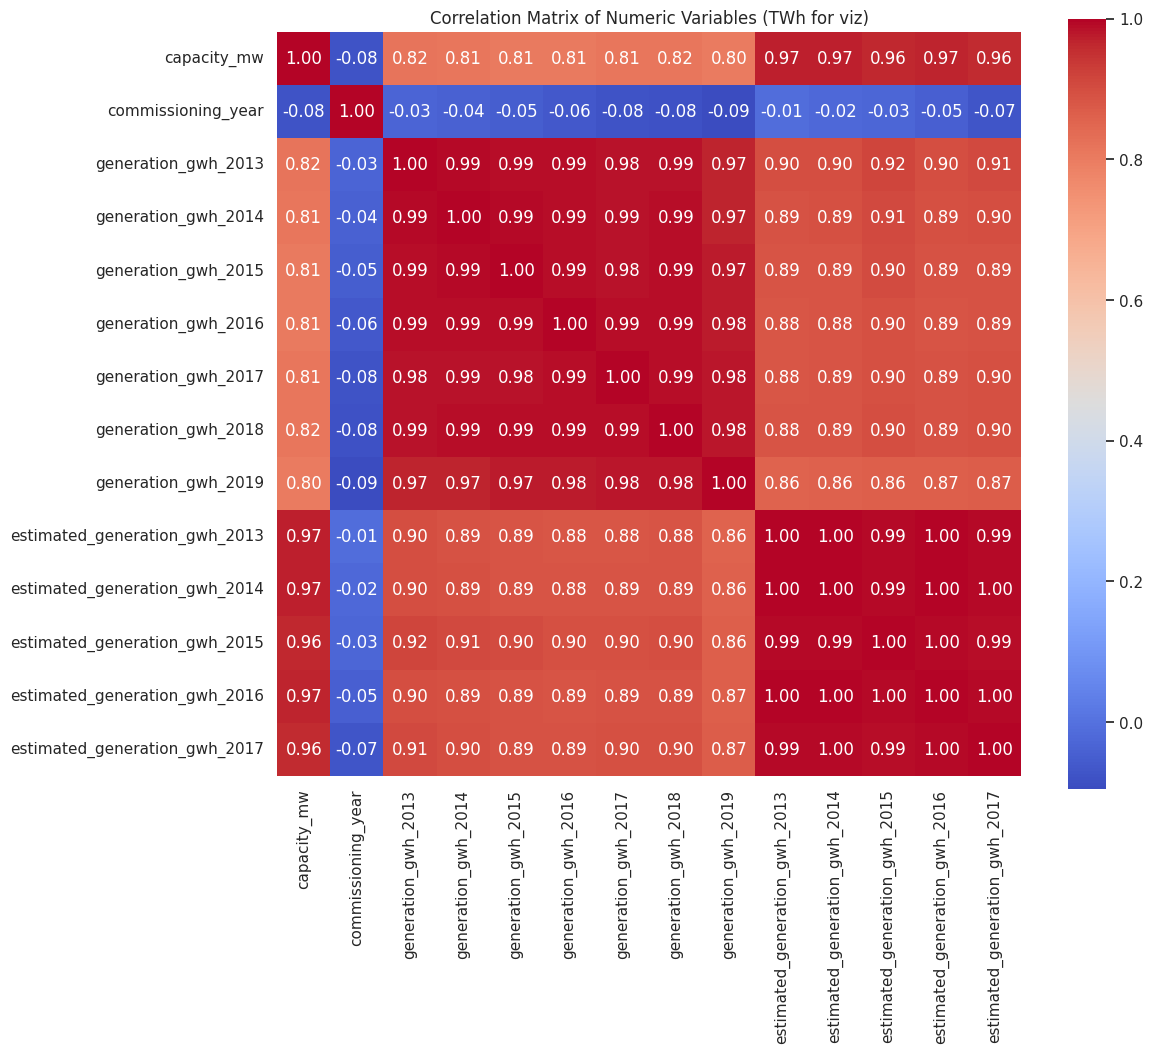

In [12]:
# Convert generation columns to numeric (raw data = GWh → convert to TWh)
for col in [
    'generation_gwh_2013','generation_gwh_2014','generation_gwh_2015','generation_gwh_2016','generation_gwh_2017','generation_gwh_2018','generation_gwh_2019',
    'estimated_generation_gwh_2013','estimated_generation_gwh_2014','estimated_generation_gwh_2015','estimated_generation_gwh_2016','estimated_generation_gwh_2017'
]:
    df[col] = pd.to_numeric(df[col], errors='coerce') / 1000

# Corr plot numeric cols
corr_cols = [
    'capacity_mw','commissioning_year',
    'generation_gwh_2013','generation_gwh_2014','generation_gwh_2015',
    'generation_gwh_2016','generation_gwh_2017','generation_gwh_2018','generation_gwh_2019',
    'estimated_generation_gwh_2013','estimated_generation_gwh_2014',
    'estimated_generation_gwh_2015','estimated_generation_gwh_2016','estimated_generation_gwh_2017'
]

df_corr = df.copy()
for c in corr_cols:
    df_corr[c] = pd.to_numeric(df_corr[c], errors='coerce') / 1000.0  # TWh for viz only

corr = df_corr[corr_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Variables (TWh for viz)")
plt.show()

**Pre-Processing & Cleaning**

In [13]:
# ensure columns are numeric
num_cols = [
    'capacity_mw','commissioning_year',
    'generation_gwh_2013','generation_gwh_2014','generation_gwh_2015',
    'generation_gwh_2016','generation_gwh_2017','generation_gwh_2018','generation_gwh_2019',
    'estimated_generation_gwh_2013','estimated_generation_gwh_2014',
    'estimated_generation_gwh_2015','estimated_generation_gwh_2016','estimated_generation_gwh_2017'
]
for c in num_cols:
    df[c] = pd.to_numeric(df.get(c), errors='coerce')

# Plant age (years as of 2019)
df['plant_age'] = 2019 - df['commissioning_year']

# create buckets
def size_bucket(mw):
    if pd.isna(mw) or mw <= 0:        return "Unknown"
    if mw <= 5:                       return "Very Small"
    if mw <= 25:                      return "Small"
    if mw <= 100:                     return "Medium"
    if mw <= 500:                     return "Large"
    if mw <= 999:                     return "Very Large"
    return "Mega"
df['size_bucket'] = df['capacity_mw'].apply(size_bucket)

# 3yr mean uses past years only to avoid leakage
df['gwh_mean_3yr'] = df[['generation_gwh_2016','generation_gwh_2017','generation_gwh_2018']].mean(axis=1)

# Trend 2013->2018 (avoid using 2019)
df['gwh_trend_13_18'] = df['generation_gwh_2018'] - df['generation_gwh_2013']

# CAGR 2013->2018 (guard zeros/NaNs, avoid using 2019)
def _safe_cagr(a, b):
    if pd.isna(a) or pd.isna(b) or a <= 0 or b <= 0:
        return np.nan
    return ((b + 1.0) / (a + 1.0))**(1/5) - 1.0  # 2013 to 2018 is 5 years
df['gwh_cagr_13_18'] = np.vectorize(_safe_cagr)(df['generation_gwh_2013'], df['generation_gwh_2018'])

# Capacity factor proxy (use historical years only to avoid leakage)
mean_past_gwh = df[['generation_gwh_2016','generation_gwh_2017','generation_gwh_2018']].mean(axis=1)
df['cap_fac_proxy'] = (mean_past_gwh * 1000) / (df['capacity_mw'] * 8760)
df['cap_fac_proxy'] = df['cap_fac_proxy'].clip(lower=0, upper=1.2)

# Target for modeling (log of 2019 generation, fallback when missing)
gen_2019_gwh = df['generation_gwh_2019']
est_2019_fallback = df['estimated_generation_gwh_2017']
gen_2019_gwh = gen_2019_gwh.fillna(est_2019_fallback)
gen_2019_gwh = gen_2019_gwh.clip(lower=0)
df['target_log'] = np.log1p(gen_2019_gwh)

# Feature lists used by the model
num_feats = ['capacity_mw','plant_age','gwh_mean_3yr','gwh_trend_13_18','gwh_cagr_13_18','cap_fac_proxy']
cat_feats = ['primary_fuel','size_bucket']

# Drop rows missing the target
before = len(df)
df = df.dropna(subset=['target_log']).copy()
print(f"✅ Dropped {before - len(df)} rows due to missing target.  Rows remaining: {len(df):,}")

✅ Dropped 113 rows due to missing target.  Rows remaining: 7,028


In [14]:
# Target (log1p of 2019 GWh) with safe fallback (no est_2019 column exists)
import numpy as np
import pandas as pd

# Simple per-row fallback to estimate 2019 if actual is missing
def fallback_est_2019(row):
    e2017 = row.get('estimated_generation_gwh_2017')
    e2016 = row.get('estimated_generation_gwh_2016')
    if pd.notna(e2017):
        # linear extrapolation from 2016→2017 to 2019 (very simple, capped >=0)
        if pd.notna(e2016):
            est = e2017 + (e2017 - e2016)  # project one more step
            return max(est, 0.0)
        return max(e2017, 0.0)
    # otherwise fall back to the latest available earlier estimate
    for y in [2016, 2015, 2014, 2013]:
        v = row.get(f'estimated_generation_gwh_{y}')
        if pd.notna(v):
            return max(v, 0.0)
    return np.nan

# Build the target series (prefer actual 2019; else fallback)
gen_2019_actual = pd.to_numeric(df.get('generation_gwh_2019'), errors='coerce')
est_2019_fallback = df.apply(fallback_est_2019, axis=1)

gen_2019_gwh = gen_2019_actual.fillna(est_2019_fallback).clip(lower=0)
df['target_log'] = np.log1p(gen_2019_gwh)

# Keep rows that have a target; let the pipeline impute feature NaNs
df = df.dropna(subset=['target_log']).copy()
print(f"Target ready. Rows remaining: {len(df):,}")


Target ready. Rows remaining: 7,028


In [15]:
# Preprocess pipe
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale',   StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe',     OneHotEncoder(handle_unknown='ignore'))
])

## Preprocessing

**Data Splitting**

In [16]:
X = df[num_feats + cat_feats]
y = df['target_log']

# Get the indices of the numerical and categorical features
# This is necessary because ColumnTransformer expects indices when the input is a numpy array
num_indices = [X.columns.get_loc(col) for col in num_feats]
cat_indices = [X.columns.get_loc(col) for col in cat_feats]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_indices),
        ('cat', categorical_pipe, cat_indices),
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20, random_state=42, shuffle=True
)

In [17]:
# Metrics + eval helper(s)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model_name_list, r2_list_gwh, mae_list_gwh, rmse_list_gwh = [], [], [], []

def save_model_metrics(name, r2_gwh, mae_gwh, rmse_gwh):
    model_name_list.append(name)
    r2_list_gwh.append(r2_gwh)
    mae_list_gwh.append(mae_gwh)
    rmse_list_gwh.append(rmse_gwh)

def create_metrics_table():
    return pd.DataFrame({
        'Model Name': model_name_list,
        'R² (GWh)': r2_list_gwh,
        'MAE (GWh)': mae_list_gwh,
        'RMSE (GWh)': rmse_list_gwh
    })

def eval_and_store(name, estimator, preprocessor, X_train, y_train, X_test, y_test):
    """Fit (preprocessor -> estimator) on log target; report metrics in GWh."""
    pipe = Pipeline([('prep', preprocessor), ('model', estimator)])
    pipe.fit(X_train, y_train)

    y_pred_log = pipe.predict(X_test)
    y_pred_gwh = np.expm1(y_pred_log)
    y_true_gwh = np.expm1(y_test)

    r2_gwh   = r2_score(y_true_gwh, y_pred_gwh)
    mae_gwh  = mean_absolute_error(y_true_gwh, y_pred_gwh)
    rmse_gwh = np.sqrt(mean_squared_error(y_true_gwh, y_pred_gwh))

    print(f"\n{name} — GWh metrics")
    print(f"R²: {r2_gwh:.6f} | MAE: {mae_gwh:.6f} GWh | RMSE: {rmse_gwh:.6f} GWh")

    save_model_metrics(name, r2_gwh, mae_gwh, rmse_gwh)
    return pipe, y_true_gwh, y_pred_gwh

**Modeling and Evaluation**

## Modeling

### Baseline Model

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [19]:
from sklearn.linear_model import LinearRegression
lin_pipe, y_true_lin, y_pred_lin = eval_and_store(
    "Linear Regression", LinearRegression(),
    preprocessor, X_train, y_train, X_test, y_test
)


Linear Regression — GWh metrics
R²: 0.862961 | MAE: 0.065924 GWh | RMSE: 0.317733 GWh


**Cross-Validation and Hyperparameter Tuning**

#### L1 and L2, ElasticNet

##### L1 Regulated Regression (Lasso) w/5 Repeated 10-fold CV

In [20]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.linear_model import Lasso, Ridge, ElasticNet

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Lasso
lasso = Lasso(random_state=42, max_iter=100000)
gs_lasso = GridSearchCV(
    Pipeline([('prep', preprocessor), ('model', lasso)]),
    param_grid={'model__alpha':[0.0001,0.0005,0.001,0.002,0.003,0.004,0.005,0.01,0.1,1,10,100]},
    cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)
gs_lasso.fit(X_train, y_train)
print("Best parameters (Lasso):", gs_lasso.best_params_)
best_lasso = gs_lasso.best_estimator_
_ , y_true_l1, y_pred_l1 = eval_and_store(
    "L1 Regulated Regression (Lasso)", best_lasso.named_steps['model'],
    preprocessor, X_train, y_train, X_test, y_test
)

Best parameters (Lasso): {'model__alpha': 0.0001}

L1 Regulated Regression (Lasso) — GWh metrics
R²: 0.887393 | MAE: 0.064573 GWh | RMSE: 0.288020 GWh


##### L2 Regulated Regression (Ridge) w/5 repeated 10-fold CV

In [21]:
ridge = Ridge(random_state=42)
gs_ridge = GridSearchCV(
    Pipeline([('prep', preprocessor), ('model', ridge)]),
    param_grid={'model__alpha':[0.001,0.01,0.1,0.5,1,2,3,4,5,10,100]},
    cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)
gs_ridge.fit(X_train, y_train)
print("Best parameters (Ridge):", gs_ridge.best_params_)
best_ridge = gs_ridge.best_estimator_
_ , y_true_l2, y_pred_l2 = eval_and_store(
    "L2 Regulated Regression (Ridge)", best_ridge.named_steps['model'],
    preprocessor, X_train, y_train, X_test, y_test
)

Best parameters (Ridge): {'model__alpha': 0.5}

L2 Regulated Regression (Ridge) — GWh metrics
R²: 0.871890 | MAE: 0.065511 GWh | RMSE: 0.307207 GWh


##### ElasticNet Regulated Regression w/5 repeated 10-fold CV

In [22]:
# Elastic Net (with tuning)
enet = ElasticNet(random_state=42, max_iter=100000)
gs_enet = GridSearchCV(
    Pipeline([('prep', preprocessor), ('model', enet)]),
    param_grid={
        'model__alpha':[0.001,0.01,0.1,1,10,100],
        'model__l1_ratio':[0.1,0.5,0.7,0.9,0.95,1.0]
    },
    cv=cv, scoring='neg_mean_squared_error', n_jobs=-1
)
gs_enet.fit(X_train, y_train)
print("Best parameters (Elastic Net):", gs_enet.best_params_)
best_enet = gs_enet.best_estimator_
_ , y_true_en, y_pred_en = eval_and_store(
    "ElasticNet Regulated Regression", best_enet.named_steps['model'],
    preprocessor, X_train, y_train, X_test, y_test
)

Best parameters (Elastic Net): {'model__alpha': 0.001, 'model__l1_ratio': 0.1}

ElasticNet Regulated Regression — GWh metrics
R²: 0.925834 | MAE: 0.061106 GWh | RMSE: 0.233745 GWh


#### SVM

##### SVM w/5 repeated 10-fold CV

In [23]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Build the full pipeline first
svr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('model', SVR())
])

# Grid must use 'model__' prefix because 'model' is the name of the step in the pipeline
param_grid_svr = {
    'model__C': [0.1, 1.0, 10.0],
    'model__epsilon': [0.01, 0.1, 0.2],
    'model__kernel': ['rbf']
}

# GridSearchCV wraps the whole pipeline
grid_svr = GridSearchCV(
    estimator=svr_pipeline,  # ✅ Full pipeline
    param_grid=param_grid_svr,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

# Pass grid_svr into eval_and_store
svr_pipe, y_true_svr, y_pred_svr = eval_and_store(
    "Support Vector Machines (GridSearch)",
    grid_svr,         # ✅ Now it's a pipeline with named steps
    preprocessor,     # Will be ignored since pipeline includes it already
    X_train, y_train,
    X_test, y_test
)

print("\nBest SVM Parameters:", svr_pipe.named_steps['model'].best_params_)


Support Vector Machines (GridSearch) — GWh metrics
R²: 0.962732 | MAE: 0.033423 GWh | RMSE: 0.165695 GWh

Best SVM Parameters: {'model__C': 10.0, 'model__epsilon': 0.01, 'model__kernel': 'rbf'}


#### Decision Tree

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Parameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dt,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

dt_pipe, y_true_dt, y_pred_dt = eval_and_store(
    "Decision Tree (GridSearch)",
    grid_dt,
    preprocessor,
    X_train, y_train,
    X_test, y_test
)

print("\nBest Decision Tree Parameters:", dt_pipe.named_steps['model'].best_params_)

#### Random Forest

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

rf_pipe, y_true_rf, y_pred_rf = eval_and_store(
    "Random Forest (GridSearch)",
    grid_rf,
    preprocessor,
    X_train, y_train,
    X_test, y_test
)

print("\nBest RF Parameters:", rf_pipe.named_steps['model'].best_params_)

##### Boosting

In [ ]:
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor

param_grid_gb = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

grid_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    scoring='neg_mean_squared_error',
    cv=5,
    n_jobs=-1
)

gb_pipe, y_true_gb, y_pred_gb = eval_and_store(
    "Gradient Boosting (GridSearch)",
    grid_gb,
    preprocessor,
    X_train, y_train,
    X_test, y_test
)

print("\nBest Gradient Boosting Parameters:", gb_pipe.named_steps['model'].best_params_)

In [ ]:
metrics_df = create_metrics_table()
print(metrics_df.sort_values(by="R² (GWh)", ascending=False))

**Results Visualization**

In [ ]:
# gather all preds
preds = {
    "Linear Regression": (y_true_lin, y_pred_lin),
    "L1 Regulated Regression (Lasso)": (y_true_l1, y_pred_l1),
    "L2 Regulated Regression (Ridge)": (y_true_l2, y_pred_l2),
    "ElasticNet Regulated Regression": (y_true_en, y_pred_en),
    "Support Vector Machines": (y_true_svr, y_pred_svr),
    "Decision Tree": (y_true_dt, y_pred_dt),
    "Random Forest": (y_true_rf, y_pred_rf),
    "Gradient Boosting": (y_true_gb, y_pred_gb),
}

def plot_all_residuals(preds_dict, bins=40):
    n = len(preds_dict)
    fig, axes = plt.subplots(n, 2, figsize=(14, 3*n))
    if n == 1:
        axes = np.array([axes])

    for i, (name, (y_true, y_pred)) in enumerate(preds_dict.items()):
        resid = y_true - y_pred
        ax1, ax2 = axes[i, 0], axes[i, 1]

        ax1.scatter(y_pred, resid, s=10, alpha=0.6)
        ax1.axhline(0, ls='--', c='red', lw=1)
        ax1.set_title(f"Residuals vs Predicted: {name}")
        ax1.set_xlabel("Predicted (GWh)")
        ax1.set_ylabel("Residuals (GWh)")
        ax1.grid(True, alpha=0.3)

        ax2.hist(resid, bins=bins)
        ax2.set_title(f"Residual Distribution: {name}")
        ax2.set_xlabel("Residuals (GWh)")
        ax2.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

plot_all_residuals(preds, bins=40)

In [ ]:
# The confidence level interval is based on the prediction of the target for the first 5 instances.

from scipy import stats

def print_prediction_cis_for_all(preds_dict, k=5, confidence_level=0.95):
    alpha  = 1 - confidence_level
    z_crit = stats.norm.ppf(1 - alpha/2)

    for name, (y_true, y_pred) in preds_dict.items():
        resid   = y_true - y_pred
        se_pred = resid.std(ddof=1)          # one global SE/ model
        margin  = z_crit * se_pred
        ci_lo   = y_pred - margin
        ci_hi   = y_pred + margin

        print(f"\n{name} — Prediction CIs (GWh, {confidence_level*100:.0f}%):")
        for i in range(min(k, len(y_pred))):
            print(f"  Pred: {y_pred[i]:.2f}  CI: ({ci_lo[i]:.2f}, {ci_hi[i]:.2f})")

print_prediction_cis_for_all(preds, k=5, confidence_level=0.95)

### Dataframe of 2019 Sustainable Energy

### Dataframe of 2028 Sustainable Energy

In [ ]:
def build_2028_from_clean(df_clean, fuel_growth=None, seed=42):
    import numpy as np
    import pandas as pd

    # Set default fuel growth if not passed in
    if fuel_growth is None:
        fuel_growth = {
            'Solar': 3.0,
            'Wind': 2.0,
            'Hydro': 1.5,
            'Biomass': 1.3,
            'Geothermal': 1.3
        }

    # Clone base data
    df_2028 = df_clean.copy()
    rng = np.random.default_rng(seed)

    # Apply fuel-based GWh growth
    hist_year_cols = [f'generation_gwh_{y}' for y in range(2013, 2020)]
    for fuel, factor in fuel_growth.items():
        mask = df_2028['primary_fuel'] == fuel
        for col in hist_year_cols:
            if col in df_2028.columns:
                df_2028.loc[mask, col] *= factor

    # Add synthetic plant growth
    def _size_bucket(mw):
        if pd.isna(mw) or mw <= 0: return 'Unknown'
        if mw <= 5: return 'Very Small'
        if mw <= 25: return 'Small'
        if mw <= 100: return 'Medium'
        if mw <= 500: return 'Large'
        if mw <= 999: return 'Very Large'
        return 'Mega'

    df_2028['size_bucket'] = df_2028['capacity_mw'].apply(_size_bucket)

    # Drop 10% of small plants
    drop_small = df_2028[df_2028['size_bucket'].str.contains('Small')].sample(frac=0.10, random_state=seed).index
    df_2028 = df_2028.drop(index=drop_small)

    # Duplicate 10% of medium plants
    medium_mask = df_2028['size_bucket'].str.contains('Medium')
    medium_add = df_2028[medium_mask].sample(frac=0.10, random_state=seed, replace=True)
    noise = rng.normal(0, 0.02, size=len(medium_add))
    medium_add['capacity_mw'] *= (1 + noise)
    df_2028 = pd.concat([df_2028, medium_add], ignore_index=True)

    # Duplicate 5% of large plants
    large_mask = df_2028['size_bucket'].str.contains('Large')
    large_add = df_2028[large_mask].sample(frac=0.05, random_state=seed, replace=True)
    noise = rng.normal(0, 0.02, size=len(large_add))
    large_add['capacity_mw'] *= (1 + noise)
    df_2028 = pd.concat([df_2028, large_add], ignore_index=True)

    # Update plant age to 2028
    df_2028['plant_age'] = 2028 - pd.to_numeric(df_2028['commissioning_year'], errors='coerce')

    # Recalculate size_bucket after growth
    df_2028['size_bucket'] = df_2028['capacity_mw'].apply(_size_bucket)

    return df_2028

In [ ]:
def engineer_features_like_training(df_any: pd.DataFrame, num_feats, cat_feats) -> pd.DataFrame:
    d = df_any.copy()

    # rolling mean 2017–2019 (ignore NaNs)
    cols_3yr = [c for c in ['generation_gwh_2017','generation_gwh_2018','generation_gwh_2019'] if c in d.columns]
    d['gwh_mean_3yr'] = d[cols_3yr].mean(axis=1) if cols_3yr else np.nan

    # trend 2013→2019 (difference)
    if {'generation_gwh_2013','generation_gwh_2019'} <= set(d.columns):
        d['gwh_trend_13_19'] = d['generation_gwh_2019'] - d['generation_gwh_2013']
    else:
        d['gwh_trend_13_19'] = np.nan

    # CAGR 2013–2019 (guard)
    def _safe_cagr(a,b):
        if pd.isna(a) or pd.isna(b) or a<=0 or b<=0: return np.nan
        return ( (b+1.0)/(a+1.0) )**(1/6) - 1.0
    if {'generation_gwh_2013','generation_gwh_2019'} <= set(d.columns):
        d['gwh_cagr_13_19'] = np.vectorize(_safe_cagr)(d['generation_gwh_2013'], d['generation_gwh_2019'])
    else:
        d['gwh_cagr_13_19'] = np.nan

    # Cap factor proxy (dimensionless), fallback to estimated if actual missing
    gen2019 = d.get('generation_gwh_2019')
    if gen2019 is None:
        gen2019 = d.get('estimated_generation_gwh_2019')
    if gen2019 is not None:
        d['cap_fac_2019'] = (pd.to_numeric(gen2019, errors='coerce')*1000) / (d['capacity_mw']*8760)
        d['cap_fac_2019'] = d['cap_fac_2019'].clip(lower=0, upper=1.2)
    else:
        d['cap_fac_2019'] = np.nan

    # ensure required columns exist
    missing = [c for c in (num_feats+cat_feats) if c not in d.columns]
    if missing:
        raise ValueError(f"Missing required features: {missing}")

    return d[num_feats + cat_feats].copy()

In [ ]:
def predict_total(pipe, features_df) -> float:
    """Returns total TWh."""
    preds_gwh = pipe.predict(features_df)
    total_gwh = preds_gwh.sum()
    return float(total_gwh/1000.0)

# 4) 2019 back-test (optional)
def backtest_2019_total(df_base, pipe, num_feats, cat_feats):
    mask = df_base['generation_gwh_2019'].notna()
    feats_2019 = engineer_features_like_training(df_base[mask], num_feats, cat_feats)
    pred_twh = predict_total(pipe, feats_2019)
    actual_twh = df_base.loc[mask, 'generation_gwh_2019'].sum()/1000.0
    err_pct = (pred_twh - actual_twh) / actual_twh * 100
    return pred_twh, actual_twh, err_pct

In [ ]:
# Build 2028 forecast dataset & generate features with the same logic used for training
df_2028 = build_2028_from_clean(df)

df_2028_features = engineer_features_like_training(df_2028, num_feats, cat_feats)

# Predict total 2028 generation using trained pipeline
pred_2028_twh = predict_total(gb_pipe, df_2028_features)

In [ ]:
import matplotlib.pyplot as plt

def plot_history_and_2028(df_base, pred_2028_twh,
                          max_capacity_twh=1200,
                          low_2019=150, high_2019=200,
                          low_2028=325, high_2028=580):
    years_hist = np.arange(2013, 2020)

    actual_twh = df_base[[f'generation_gwh_{y}' for y in years_hist]].sum(numeric_only=True).values/1000.0
    # interpolate estimated to full range
    est_series = df_base[[f'estimated_generation_gwh_{y}' for y in range(2013,2018)]].sum(numeric_only=True)
    est_series = est_series.reindex([f'estimated_generation_gwh_{y}' for y in years_hist]).interpolate('linear')
    estimated_twh = est_series.values/1000.0

    # demand band 2019→2028
    band_years = np.arange(2019, 2029)
    low_band  = np.linspace(low_2019,  low_2028,  len(band_years))
    high_band = np.linspace(high_2019, high_2028, len(band_years))

    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(years_hist, actual_twh,   marker='o', color='navy',   label='Actual Generation (TWh)')
    ax.plot(years_hist, estimated_twh,marker='s', color='orange', label='Estimated Generation (TWh)')
    ax.axhline(max_capacity_twh, color='green', linestyle='--', linewidth=1.5,
               label='Realistic Max Renewable Generation (TWh)')
    ax.fill_between(band_years, low_band, high_band, color='pink', alpha=0.35,
                    label='Data Center Demand Range (TWh)')
    ax.scatter([2028],[pred_2028_twh], s=110, color='purple', zorder=5,
               label=f'2028 RF Predicted Generation ({pred_2028_twh:.1f} TWh)')
    ax.set_title('Actual vs Estimated Renewable Generation vs Data Center Use (North America)')
    ax.set_xlabel('Year'); ax.set_ylabel('Total Generation (TWh)')
    ax.set_xlim(2012.5, 2028.5); ax.grid(True, ls='--', alpha=0.4)
    ax.legend(loc='upper left', frameon=True); plt.tight_layout(); plt.show()

In [ ]:
# 1. Clean and prep the base dataset
gen_2019_actual = pd.to_numeric(df['generation_gwh_2019'], errors='coerce')
est_2019_fallback = df.apply(fallback_est_2019, axis=1)
gen_2019_gwh = gen_2019_actual.fillna(est_2019_fallback).clip(lower=0)

# Define target for modeling
df['target_log'] = np.log1p(gen_2019_gwh)

# Filter out rows with no valid target
df_clean = df.dropna(subset=['target_log']).copy()

# Build 2028 future scenario
df_2028 = build_2028_from_clean(df_clean)

# Engineer features for prediction using same logic as training
df_2028_features = engineer_features_like_training(df_2028, num_feats, cat_feats)

# Predict 2028 generation using trained Gradient Boosting model
pred_2028_twh = predict_total(gb_pipe, df_2028_features)

# Optional back-test on 2019 to check model fit
pred_2019_twh, actual_2019_twh, err_2019 = backtest_2019_total(df_clean, gb_pipe, num_feats, cat_feats)

# Display results
print(f"2028 GB Predicted Total: {pred_2028_twh:.1f} TWh")

# Scale up prediction to full dataset size (since we used only a subset)
test_fraction = 0.20
scaled_pred_2028_twh = pred_2028_twh / test_fraction
print(f"📈 Scaled 2028 GB Prediction (Full Dataset): {scaled_pred_2028_twh:.1f} TWh")

**Conclusion and Takeaways (Tables comparing performance metrics)**
Conclusion
- Summary of findings
- Best performing model: [e.g., Random Forest with X% accuracy]
- Insights from EDA and feature importance
- Limitations and potential next steps